### PANOPTES State Machine

This notebook gives an example run through of the PANOPTES State Machine (PSM). Below we manually walk through the various states so we can explain what happens along the way. When PANOPTES is actually running these steps will automatically transition.

In [1]:
# Load the PANOPTES module dir
from IPython.display import Image
import sys
sys.path.append('../')

from panoptes.core import Panoptes

#### Create

The first step is to create an instance of our `Panoptes` class. Here we instantiate a simulator version. Possible values for the simulator include: `all`, `weather`, `mount`, `camera`

In [2]:
pan = Panoptes(simulator=['all'])

18:18:20 UTC - ********************************************************************************
18:18:20 UTC - Initializing PANOPTES unit
18:18:20 UTC - Welcome PAN001!
18:18:20 UTC - Loading state table
18:18:20 UTC - 	 messaging system
18:18:20 UTC - 	 weather station
18:18:20 UTC - 	 observatory
18:18:20 UTC - 	Initializing observatory
18:18:20 UTC - 		 Setting up location
18:18:20 UTC - 		 Setting up mount
18:18:20 UTC - 		Using simulator mount
18:18:20 UTC - 		 Setting up cameras
18:18:20 UTC - 		 Using simulator camera
18:18:20 UTC - 		 Using simulator camera
18:18:20 UTC - 		 Setting up scheduler
18:18:21 UTC - 	 Observatory initialized
18:18:21 UTC - PAN001 says: Hi! I'm all set to go!


Above you see the log output from the unit. Here `PAN001` is the name of the unit. The messages that start with `PAN001 says:` are intended to be user-friendly messages. Full debug log output is written to `/var/panoptes/log/panoptes.log`.

In [3]:
graph = pan.get_graph()

parked
parking
shutdown
sleeping
ready
scheduling
slewing
tracking
observing
analyzing


In [4]:
graph.draw('state.png', prog='dot')

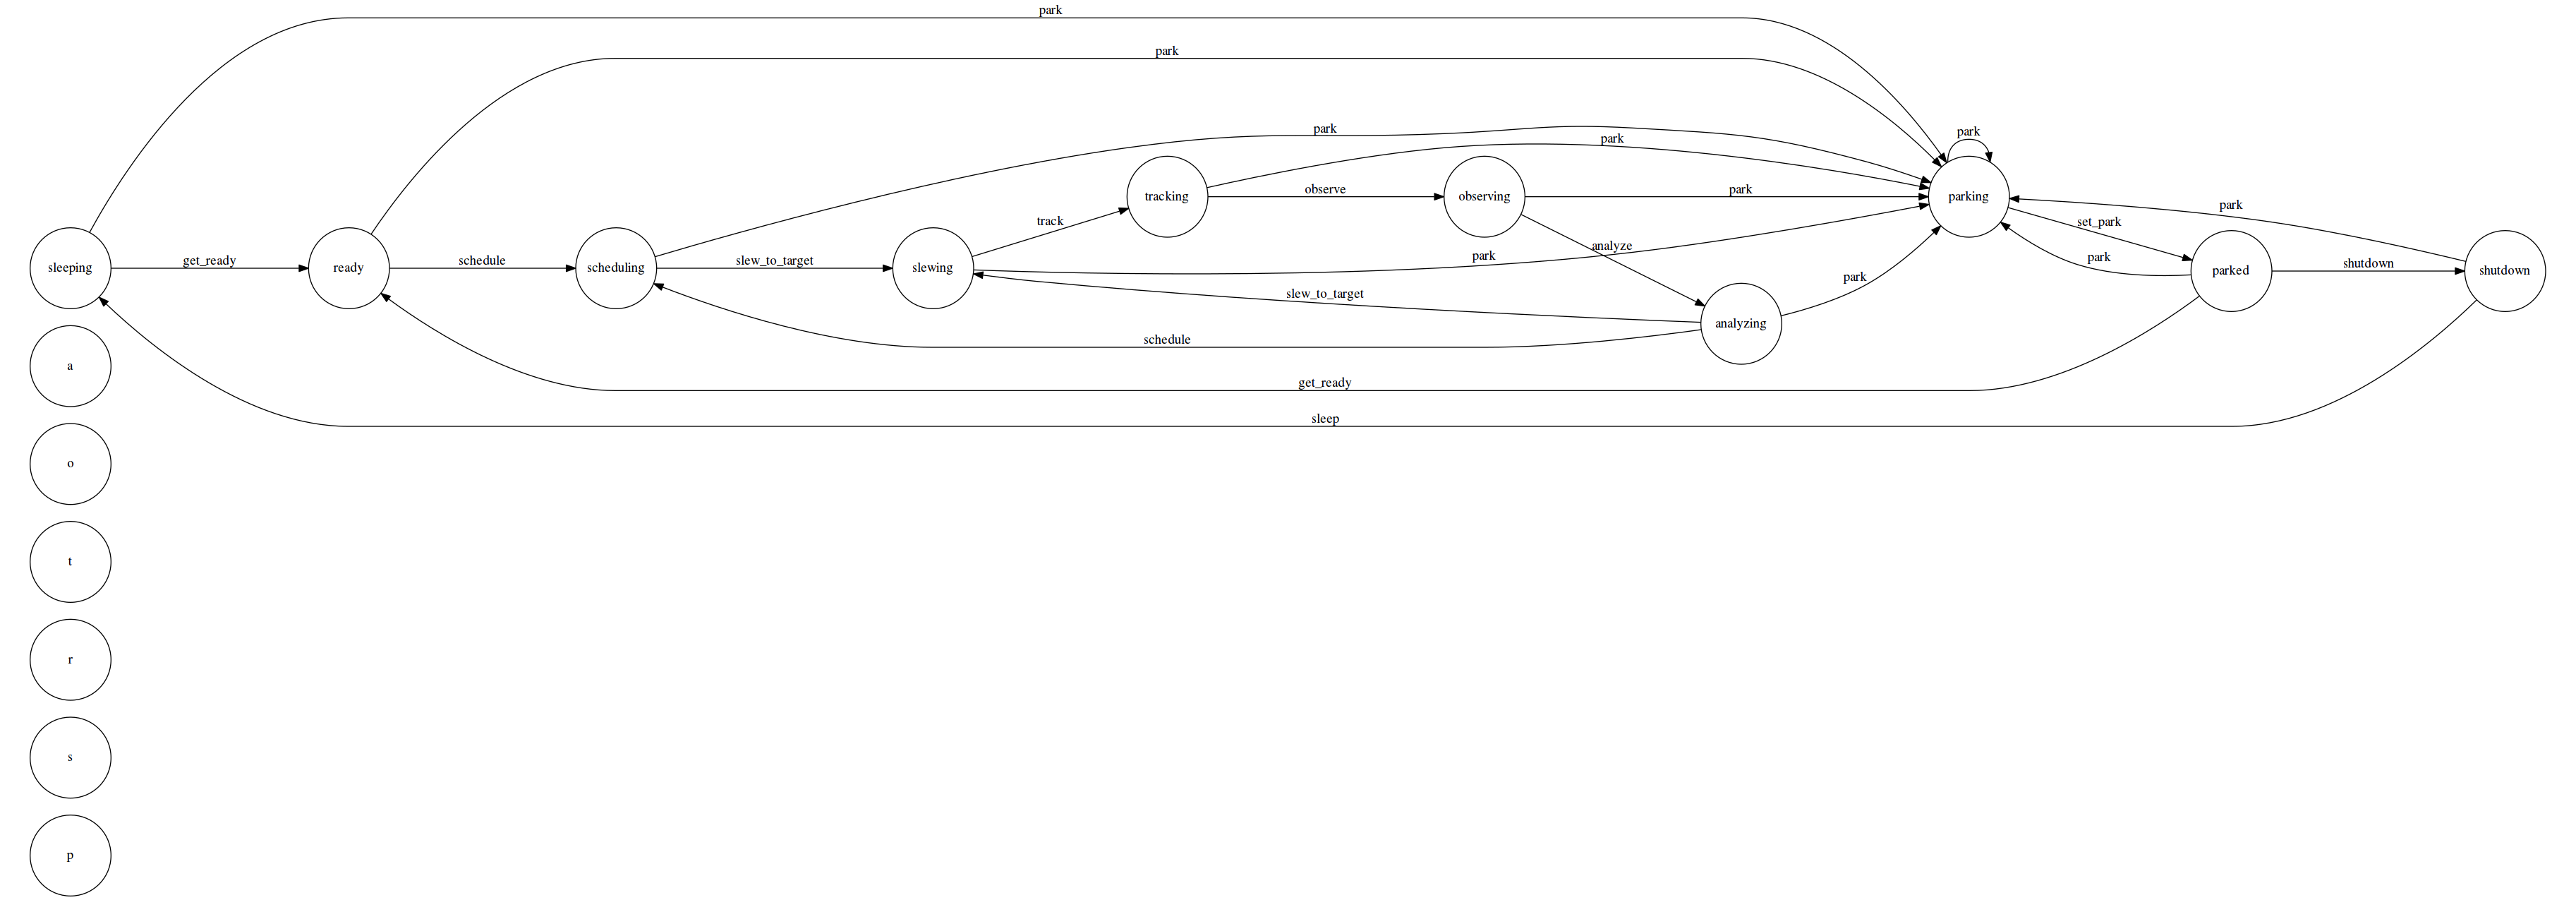

In [5]:
Image('state.png')

#### Get Ready!

Our unit is now up and running, sitting in the default state of `parked`. The first thing we want to do is get our unit in the `ready` __state__. To do this, we call `get_ready()`, which is the __transition__.

In [ ]:
# Call the transition to go from parked->ready
pan.get_ready()

We can double check which state we are currently in with:

In [ ]:
pan.state

#### Schedule

Our unit is now initialized and ready to start processing for the night. The first thing to do is send the unit to the `scheduling` state via the `schedule()` transition:

In [ ]:
pan.schedule()

The output above indicates that we successfully found a target to look at. Let's double-check that we are now in the `scheduling` state still:

In [ ]:
pan.state

In [ ]:
pan.slew_to_target()

In [ ]:
pan.track()

In [ ]:
pan.state

In [ ]:
pan.park()

In [ ]:
pan.set_park()

In [ ]:
pan.shutdown()

In [ ]:
pan.sleep()